In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [2]:
# linear function, computes k-th coordinate by k-1 first
#   coefficients - k-1-dim array
#   x - k-1-dim array
def f(coefficients, x):
    return np.sum(coefficients * x)

class point_set:
    # n - amount of points
    # dim - space's dim
    # coords_bound - upper bound on absolute first k-1 coordinates value
    # coefficients_bound - upper bound on absolute coefficients value
    def __init__(self, n, dim, coords_bound, coefficients_bound):
        self.n = n
        self.dim = dim
        self.x = coords_bound * np.random.random_sample((n, dim - 1))
        coefficients = coefficients_bound * np.random.random_sample((dim - 1))
        self.y = np.asarray([])
        for i in range(0, n):
            self.y = np.append(self.y, f(coefficients, self.x[i]))
        

input_2d = point_set(100, 2, 5., 1.)
input_3d = point_set(200, 3, 5., 1.)
input_small = point_set(100, 5, 5., 1.)
input_large = point_set(100, 20, 5, 1.)

In [3]:
# # amount of points
# n = 9 
# # dimension of x points
# k = 1
# # points: x - n k-dim points
# #         y - n 1-dim points
# x = np.asarray([[10], [12], [15], [17], [18], [19], [20], [21], [171]])
# y = np.asarray([6, 6, 7, 7, 7, 8, 9, 10, 77])

In [4]:
# considered linear regression for points_set
# f = sum from i=0 to n-1 of (a*x_i + b - y_i)^2, where a.append(b) = c
#   points - point_set
#   c - k-dim array of coefficients points = [a_0, ..., a_k-2, b]
def linear_regression(points, c):
    f = 0
    for i in range(0, points.n):
        f += (np.sum(c[0 : points.dim - 1] * points.x[i]) + c[points.dim - 1] - points.y[i]) ** 2
    return f

In [5]:
# calculate gradient [d/da, d/db] of linear regression for points_set by variables x_i, where i in ids
#   points - point_set
#   ids - array of indices for taking gradient
#   coeffs - current linear regression = [a_0, ..., a_k-2, b]
def linear_regression_grad(points, ids, coeffs):
    a = coeffs[0 : points.dim - 1]
    b = coeffs[points.dim - 1]
    grad_a = np.asarray([0.] * len(a))
    grad_b = 0.
    for i in ids:
        grad_a += 2 * (np.sum(a * points.x[i]) + b - points.y[i]) * points.x[i]
        grad_b += 2 * (np.sum(a * points.x[i]) + b - points.y[i])
    return np.append(grad_a, grad_b)

In [6]:
# find arg of multidim function f with min value by eps, lr() - lambda, x - starting point
# "gradient descent with additional information"
def sgd(points, batch_size, gradinet_supplier, starting_coeffs, lr, eps, epoches):
    linear_regression_value = np.asarray([[]])
    order = np.asarray(range(0, points.dim - 1))
    np.random.shuffle(order)

    batch_index = 0
    epoch_counter = 0
    coeffs = starting_coeffs
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, points.dim)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        coeffs_step = coeffs - lr * grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        else:
            epoch_counter += 1
        
        # print(linear_regression(point[0:k], point[k]))
        linear_regression_value = np.append(linear_regression_value, linear_regression(points, coeffs))
        coeffs = coeffs_step
        
        if to == points.dim:
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, epoch_counter, linear_regression_value]

# result = sgd(1, linear_regression_grad, np.asarray([0.] * (k + 1)), 0.01, 1e-6, 500)
# print(result[0])
# print(result[1])
# print(linear_regression(result[0][0:k], result[0][1:k+1]))
# print(result[2])

In [7]:
def batch_size_analyze(points):
    EPOCH_MAX = 1000
    linear_regression_value = np.asarray([])
    for batch in range(1, points.dim + 1):
        result = sgd(points, batch, linear_regression_grad, np.asarray([0.] * (points.dim)), 0.01, 1e-6, EPOCH_MAX)
        linear_regression_value = np.append(linear_regression_value, result[1])

    # print(points.x)
    # print(points.y)
    # print(points.dim)
    # print(linear_regression_value)

    #shift data left
    plt.plot(np.linspace(1, len(linear_regression_value), len(linear_regression_value)), linear_regression_value)
    plt.xlabel("batch")
    plt.ylabel("value")
    plt.title("Mini-batch SGD for n=" + str(points.n) + ", dim=" + str(points.dim))
    plt.show()

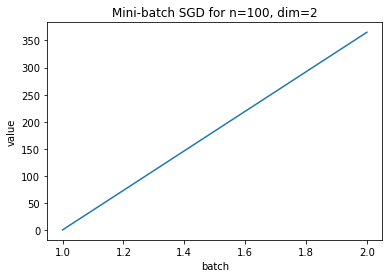

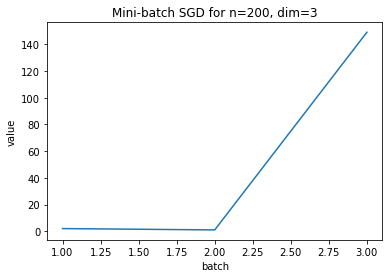

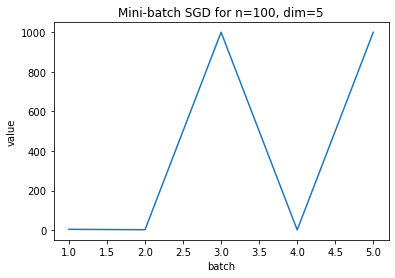

C:\Users\11\AppData\Local\Temp/ipykernel_9832/1206860804.py:8: RuntimeWarning: overflow encountered in double_scalars
  f += (np.sum(c[0 : points.dim - 1] * points.x[i]) + c[points.dim - 1] - points.y[i]) ** 2
C:\Users\11\AppData\Local\Temp/ipykernel_9832/1910732609.py:11: RuntimeWarning: overflow encountered in add
  grad_a += 2 * (np.sum(a * points.x[i]) + b - points.y[i]) * points.x[i]
C:\Users\11\AppData\Local\Temp/ipykernel_9832/2411548957.py:15: RuntimeWarning: invalid value encountered in subtract
  coeffs_step = coeffs - lr * grad
C:\Users\11\AppData\Local\Temp/ipykernel_9832/1910732609.py:11: RuntimeWarning: overflow encountered in multiply
  grad_a += 2 * (np.sum(a * points.x[i]) + b - points.y[i]) * points.x[i]
C:\Users\11\AppData\Local\Temp/ipykernel_9832/1910732609.py:12: RuntimeWarning: overflow encountered in double_scalars
  grad_b += 2 * (np.sum(a * points.x[i]) + b - points.y[i])


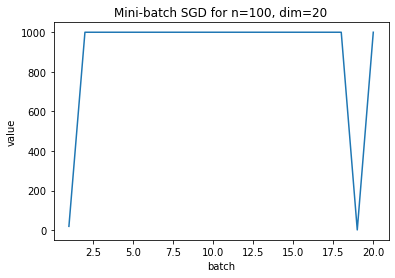

In [8]:
batch_size_analyze(input_2d)
batch_size_analyze(input_3d)
batch_size_analyze(input_small)
batch_size_analyze(input_large)

Микровывод: как можно видеть, mini-batch SGD для лин. регрессии без каких либо оптимизаций действительно сильно "скачет" в показаниях сходимости для ранзных величин batch и размерности пространства точек. В подавляющем большинстве случаев сойтись при эпсилон меньше 1 (наверняка еще и больше нужно брать) не получается даже за 1000 эпох :(